In [1]:
%matplotlib inline



# Percentile analysis - outlier detection: 

### Here we observe by doing some experiment how the percentile analysis works =)



In [2]:
from pymongo import MongoClient
from __future__ import print_function
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics 

import random
import sys
sys.path.append('../../lib')
import rs_common_framework_v4 as rs

import pandas as pd
import datetime
import collections
import numpy as np
import math

from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import cm, pyplot as plt, style as st, gridspec as gd
from matplotlib.dates import YearLocator, MonthLocator
st.use('seaborn-colorblind')

import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display

py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
n = 3000
A = 10
print("First experiment, we create a random series of length N between [-A, A] , N={0}, A={1}".format(n,A))
print("This random series is created from a random samples from a uniform distribution over [0,1], using np.random.rand")

series = 2*A*np.random.rand(n,1) - A
df_original =pd.DataFrame(series,columns=['series'])

low_quartile = np.linspace(0.01, 0.25, 24)  # lower quartile
up_quartile = np.linspace(0.75, 0.99, 24)   # upper quartile
high_limit = 1.0  # This defines the high limit using the linear regression when x=1.0
low_limit =  -0.0 # This defines the low limit using the linear regression when x=0.0


First experiment, we create a random series of length N between [-A, A] , N=3000, A=10
This random series is created from a random samples from a uniform distribution over [0,1], using np.random.rand


In [4]:
df_series = df_original.copy()
ucl = rs.get_limit_by_quartile(df_series['series'], up_quartile, high_limit)
lcl = rs.get_limit_by_quartile(df_series['series'], low_quartile, low_limit)

print('Using this approach (percentile analysis) we found: ucl = {0} and lcl = {1}'.format(ucl,lcl))
mean = df_series['series'].mean()
std = df_series['series'].std()
ucl_3std = mean + 3*std
lcl_3std = mean - 3*std
print('Using 3 sigma approach, we found: ucl_3std = {0} and lcl_3std = {1}'.format(ucl_3std,lcl_3std))
q1 = df_series['series'].quantile(0.25)
q3 = df_series['series'].quantile(0.75)
IQR = q3-q1
ucl_qtl = q3 + 1.5*IQR
lcl_qtl = q1 - 1.5*IQR
print('Using interquartile range approach, we found: ucl_qtl = {0} and lcl_qtl = {1}'.format(ucl_qtl,lcl_qtl))

df_series['LoL'] = ucl
df_series['UpL'] = lcl
df_series['ucl-3std'] = ucl_3std
df_series['lcl-3std'] = lcl_3std
df_series['ucl-IQR'] = ucl_qtl
df_series['lcl-IQR'] = lcl_qtl

Using this approach (percentile analysis) we found: ucl = 9.981397145338592 and lcl = -9.904797299909927
Using 3 sigma approach, we found: ucl_3std = 17.24098669946579 and lcl_3std = -17.428955142486895
Using interquartile range approach, we found: ucl_qtl = 20.07920404475346 and lcl_qtl = -20.210201532874482


We plot the ramdon series and the respective limits that were found by the percentile analysis


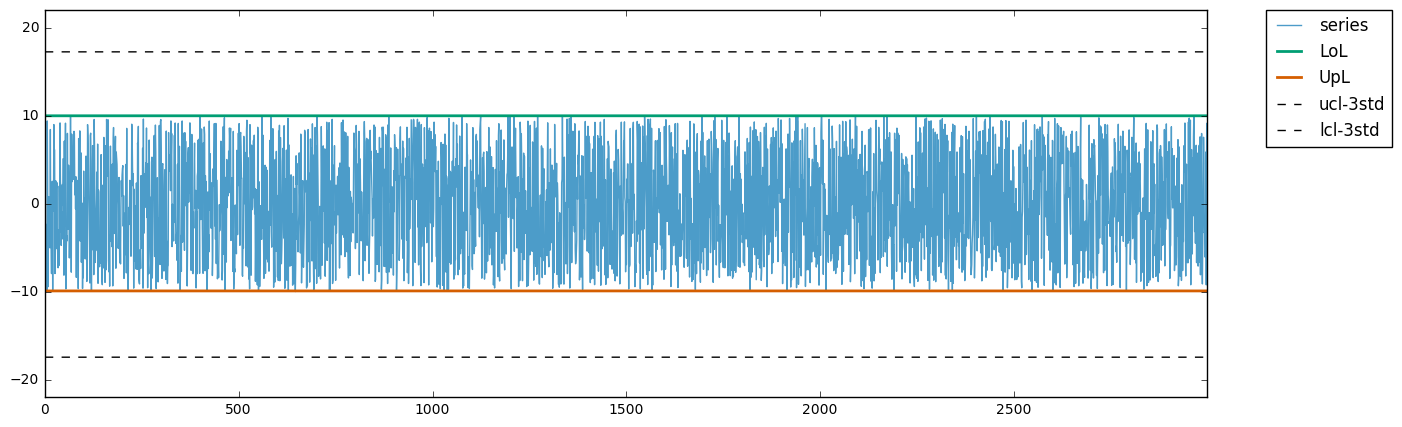

In [5]:
print('We plot the ramdon series and the respective limits that were found by the percentile analysis')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
df_series['series'].plot(ax=axes,alpha=0.7)
df_series[['LoL','UpL']].plot(ax=axes,lw=2)
df_series[['ucl-3std','lcl-3std']].plot(ax=axes,lw=1,linestyle='--', color='black')
#df_series[['ucl-IQR','lcl-IQR']].plot(ax=axes,lw=1.2,linestyle='-.', color='red')
axes.set_ylim([-22,22])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [6]:
B = 5
n_outliers = 50
n_med = int(n_outliers/2)
print('Now, we add {0} outliers and we would like to see whether these outliers were found or not.'.format(n_outliers))  
print('The amplitud of this outliers is B = {1}'.format(n_outliers, B))

idx = random.sample(list(df_original.index), n_outliers)
X1 = A + B*np.random.rand(n_med,1) 
X2 = A + B*np.random.rand(n_med,1) 

df_series['series'].loc[idx[:n_med]] =  X1 
df_series['series'].loc[idx[n_med:]] = -X2  

Now, we add 50 outliers and we would like to see whether these outliers were found or not.
The amplitud of this outliers is B = 5


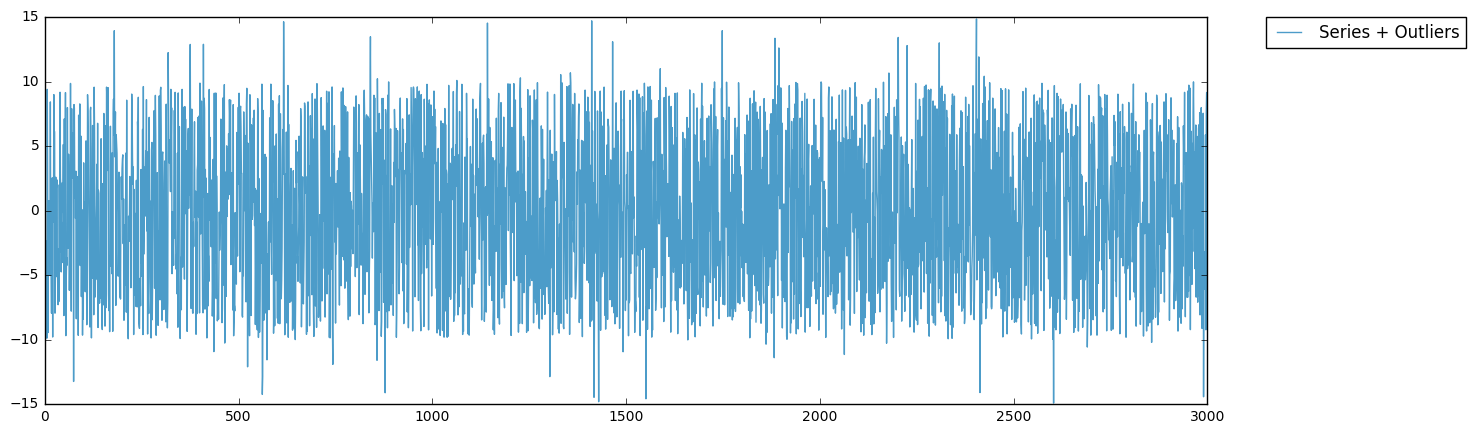

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
axes.plot(df_series['series'], label='Series + Outliers', alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [8]:
ucl = rs.get_limit_by_quartile(df_series['series'], up_quartile, high_limit)
lcl = rs.get_limit_by_quartile(df_series['series'], low_quartile, low_limit)
df_series['UpL'] = ucl
df_series['LoL'] = lcl
print('Using this approach (percentile analysis) we found: ucl = {0} and lcl = {1}'.format(ucl,lcl))
mean = df_series['series'].mean()
std = df_series['series'].std()
ucl_3std = mean + 3*std
lcl_3std = mean - 3*std
print('Using 3 sigma approach, we found: ucl_3std = {0} and lcl_3std = {1}'.format(ucl_3std,lcl_3std))
q1 = df_series['series'].quantile(0.25)
q3 = df_series['series'].quantile(0.75)
IQR = q3-q1
ucl_qtl = q3 + 1.5*IQR
lcl_qtl = q1 - 1.5*IQR
print('Using interquartile range approach, we found: ucl_qtl = {0} and lcl_qtl = {1}'.format(ucl_qtl,lcl_qtl))

Using this approach (percentile analysis) we found: ucl = 10.151900654188266 and lcl = -10.058996894306134
Using 3 sigma approach, we found: ucl_3std = 17.761728853317102 and lcl_3std = -17.974893547750106
Using interquartile range approach, we found: ucl_qtl = 20.430575679165052 and lcl_qtl = -20.635691524745717


Now, we plot the ramdon series, the respective limits that were and the outliers that were spotted


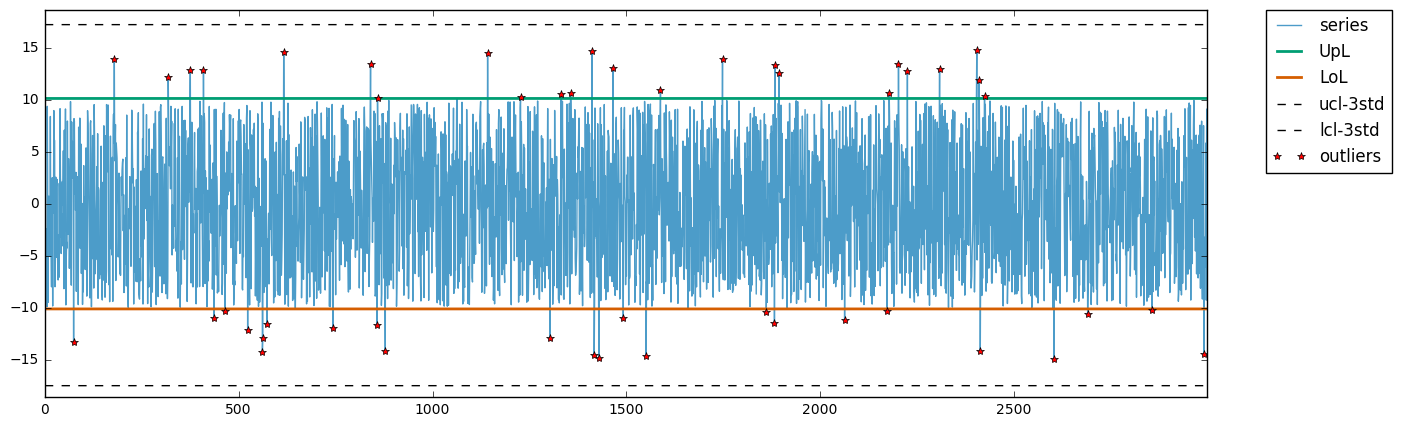

Number of spotted values: 48, which is 96.0% of the total number of ouliers


In [9]:
print('Now, we plot the ramdon series, the respective limits that were and the outliers that were spotted')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
df_series['series'].plot(ax=axes,alpha=0.7)
df_series[['UpL','LoL']].plot(ax=axes,lw=2)
df_series[['ucl-3std','lcl-3std']].plot(ax=axes,lw=1,linestyle='--', color='black')
mask1 = (df_series['series'] > ucl) | (df_series['series'] < lcl)

plt.plot(df_series[mask1].index, df_series[mask1]['series'], '*',color='red', label='outliers')

plt.ylim([lcl-1.7*B , ucl+ 1.7*B])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

n_spotted = len(df_series[mask1].index) 
print('Number of spotted values: {0}, which is {1}% of the total number of ouliers'.format(n_spotted, round(n_spotted/n_outliers*100,2)))

In [10]:
ini = 10
n_outliers = range(ini,int(n/8),4)
p, p1 = list(), list()

idx = random.sample(list(df_original.index), int(n/4))
idx1 = idx[:int(n/8)] 
idx2 = idx[int(n/8):]
X1 = sorted(A + B*np.random.rand(len(idx1),1), reverse=True)
X2 = sorted(-A - B*np.random.rand(len(idx2),1))

limit = 0
for n_outlier in list(n_outliers):
    df_series = df_original.copy()
    
    n_med = int(n_outlier/2)
    df_series['series'].loc[idx1[:n_med]] =  X1[:n_med] 
    df_series['series'].loc[idx2[:n_med]] =  X2[:n_med]
    # quartile analysis:
    ucl = rs.get_limit_by_quartile(df_series['series'], up_quartile, high_limit)
    lcl = rs.get_limit_by_quartile(df_series['series'], low_quartile, low_limit)

    mask1 = (df_series['series'] > ucl) | (df_series['series'] < lcl)
    mask1 = df_series[mask1].index
    idx_oulier = idx1[:n_med] + idx2[:n_med]
    spotted = [1 for x in mask1 if x in idx_oulier]
    n_spotted = sum(spotted)
    per = round(n_spotted/n_outlier*100,2)
    p.append(per)
    
    # six Sigma:
    mean = df_series['series'].mean()
    std = df_series['series'].std()
    ucl_3std = mean + 3*std
    lcl_3std = mean - 3*std
    
    mask1 = (df_series['series'] > ucl_3std ) | (df_series['series'] < lcl_3std)
    mask1 = df_series[mask1].index
    idx_oulier = idx1[:n_med] + idx2[:n_med]
    spotted = [1 for x in mask1 if x in idx_oulier]
    n_spotted = sum(spotted)
    per = round(n_spotted/n_outlier*100,2)
    p1.append(per)    
    
    if per < 95 and limit == 0:
        print('The detection is bellow 95% when the number of outliers = {0}'.format(n_outlier))
        print('The number of outliers is {0}% of the total series [{1}]'.format(round(n_outlier/n*100,2),n))
        limit = n_outlier

The detection is bellow 95% when the number of outliers = 10
The number of outliers is 0.33% of the total series [3000]


[]

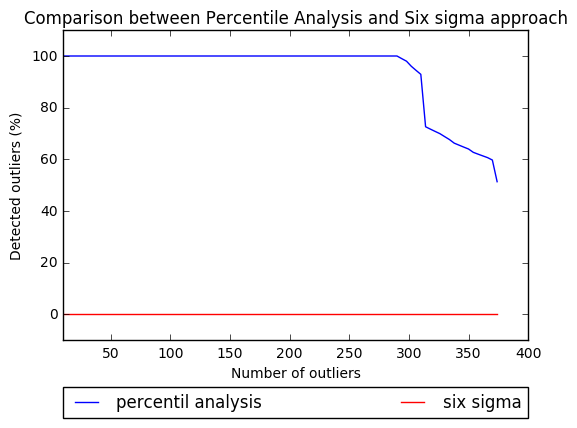

In [20]:
pl.plot(list(n_outliers),p, label='percentil analysis', color= 'blue')
pl.plot(list(n_outliers),p1, label='six sigma', color = 'red' )
pl.ylim([-10,110])
pl.xlim([10,400])
pl.title('Comparison between Percentile Analysis and Six sigma approach')
pl.xlabel('Number of outliers')
pl.ylabel('Detected outliers (%)')
pl.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
pl.plot()

In [ ]:
print('We observe the moment when this approach does not detect any outlier:')
n_outliers = [20,limit-150, limit]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
i = 0
for n_outlier in n_outliers:
    df_series = df_original.copy()
    random.sample(range(1, 100), 3)
    idx = random.sample(list(df_original.index), int(n_outlier))
    idx1 = idx[:int(n_outlier/2)]
    idx2 = idx[int(n_outlier/2):]
    df_series['series'].loc[idx1] = A + B*np.random.rand(len(idx1),1)  
    df_series['series'].loc[idx2] = -A - B*np.random.rand(len(idx2),1) 
    ucl = rs.get_limit_by_quartile(df_series['series'], up_quartile, high_limit)
    lcl = rs.get_limit_by_quartile(df_series['series'], low_quartile, low_limit)
    mask1 = df_series['series'] > ucl
    mask2 = df_series['series'] < lcl
    df_series['ucl'] = ucl 
    df_series['lcl'] = lcl
    df_series['series'].plot(ax=axes[i], alpha=0.5)
    df_series[['ucl','lcl']].plot(ax=axes[i], alpha=1, lw=3)
    axes[i].plot(df_series[mask1].index, df_series[mask1]['series'], '*',color='red' )
    axes[i].plot(df_series[mask2].index, df_series[mask2]['series'], '*',color='red' )
    axes[i].set_title(str(n_outlier) + ' outliers')
    axes[i].set_ylim([-25,25])
    i += 1

plt.show()